# Kredi Kartı Sahtekarlığı Tespiti

## Ödev 3: Sınıflandırma Modelleri Karşılaştırması

**Amaç:** YSA, XGBoost ve Random Forest modellerini kullanarak kredi kartı işlemlerinin sahte (fraud) olup olmadığının tespit edilmesi.

**Veri Seti:** [Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

---

## 1. Kütüphanelerin İçe Aktarılması

Gerekli tüm Python kütüphaneleri yükleniyor.

In [13]:
!pip install -q kagglehub xgboost

import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

print("✓ Kütüphaneler yüklendi.")

✓ Kütüphaneler yüklendi.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Veri Yükleme ve Keşifsel Veri Analizi

Veri seti Kagglehub üzerinden otomatik olarak indirilip yükleniyor. Veri setinde **284,807 işlem** bulunmakta ve bunların sadece **%0.17'si fraud** (sahte) işlemdir. Bu yüksek dengesizlik modelleme stratejimizi belirleyecektir.

In [14]:
print("Veri seti yükleniyor...")
try:
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    df = pd.read_csv(f"{path}/creditcard.csv")
except:
    df = pd.read_csv("creditcard.csv")

print(f"✓ Veri seti yüklendi: {df.shape[0]:,} satır, {df.shape[1]} sütun")
print(f"\nİlk 5 satır:")
display(df.head())

print("\n" + "="*60)
print("SINIF DAĞILIMI")
print("="*60)
fraud_count = df['Class'].value_counts()[1]
normal_count = df['Class'].value_counts()[0]
print(f"Normal İşlem: {normal_count:,}")
print(f"Fraud İşlem:  {fraud_count:,}")
print(f"Fraud Oranı:  %{(fraud_count / len(df)) * 100:.4f}")
print(f"Dengesizlik:  1:{normal_count/fraud_count:.0f}")
print("="*60)

print("\nVeri ön işleme yapılıyor...")
scaler = RobustScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print(f"✓ Veri ön işleme tamamlandı")
print(f"  Eğitim seti: {X_train.shape}")
print(f"  Test seti:   {X_test.shape}")

Veri seti yükleniyor...
✓ Veri seti yüklendi: 284,807 satır, 31 sütun

İlk 5 satır:
✓ Veri seti yüklendi: 284,807 satır, 31 sütun

İlk 5 satır:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



SINIF DAĞILIMI
Normal İşlem: 284,315
Fraud İşlem:  492
Fraud Oranı:  %0.1727
Dengesizlik:  1:578

Veri ön işleme yapılıyor...
✓ Veri ön işleme tamamlandı
  Eğitim seti: (227845, 30)
  Test seti:   (56962, 30)
✓ Veri ön işleme tamamlandı
  Eğitim seti: (227845, 30)
  Test seti:   (56962, 30)


## 3. Veri Ön İşleme

**Ölçeklendirme:** `Amount` ve `Time` özellikleri için **RobustScaler** kullanıldı. RobustScaler, aykırı değerlere (outliers) karşı daha dayanıklıdır ve fraud tespiti gibi anomali içeren veri setlerinde tercih edilir.

**Veri Bölme:** Stratified Split kullanılarak eğitim (%80) ve test (%20) setlerine ayrıldı. Stratified split, fraud oranının her iki sette de eşit kalmasını garantiler.

In [15]:
def evaluate_model(model, X_test, y_test, model_name, y_pred=None):
    if y_pred is None:
        y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    try:
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.predict(X_test).flatten()
        roc_auc = roc_auc_score(y_test, y_proba)
    except:
        roc_auc = None
    
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} SONUÇLARI")
    print(f"{'='*60}")
    
    cm_df = pd.DataFrame(cm, 
                         index=['Gerçek: Normal', 'Gerçek: Fraud'], 
                         columns=['Tahmin: Normal', 'Tahmin: Fraud'])
    print("\nConfusion Matrix:")
    print(cm_df)
    
    print(f"\nPerformans Metrikleri:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"  ROC-AUC:   {roc_auc:.4f}")
    
    print(f"\nDetaylı Analiz:")
    print(f"  Yakalanan Fraud:  {tp}")
    print(f"  Kaçırılan Fraud:  {fn}")
    print(f"  Yanlış Alarm:     {fp}")
    
    print("\nSınıflandırma Raporu:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))
    print("="*60)
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
    }

print("Random Forest eğitiliyor...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)
rf_results = evaluate_model(rf_model, X_test, y_test, "Random Forest")

Random Forest eğitiliyor...

RANDOM FOREST SONUÇLARI

Confusion Matrix:
                Tahmin: Normal  Tahmin: Fraud
Gerçek: Normal           56855              9
Gerçek: Fraud               20             78

Performans Metrikleri:
  Accuracy:  0.9995
  Precision: 0.8966
  Recall:    0.7959
  F1-Score:  0.8432
  ROC-AUC:   0.9514

Detaylı Analiz:
  Yakalanan Fraud:  78
  Kaçırılan Fraud:  20
  Yanlış Alarm:     9

Sınıflandırma Raporu:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.90      0.80      0.84        98

    accuracy                           1.00     56962
   macro avg       0.95      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962


RANDOM FOREST SONUÇLARI

Confusion Matrix:
                Tahmin: Normal  Tahmin: Fraud
Gerçek: Normal           56855              9
Gerçek: Fraud               20             78

Performans Metrikleri:
  Accuracy:  0.9995
  Pre

## 4. Model Değerlendirme Fonksiyonu ve Random Forest Eğitimi

Model performansını ölçmek için kapsamlı bir değerlendirme fonksiyonu tanımlandı. Bu fonksiyon:
- Confusion Matrix
- Accuracy, Precision, Recall, F1-Score
- ROC-AUC skoru
- True Positive (TP), False Positive (FP), False Negative (FN) detayları

gibi metrikleri hesaplıyor ve raporluyor.

### Random Forest Modeli
**Class weight balanced** parametresi ile dengesiz veri seti problemi çözülüyor.


RANDOM FOREST - ÖZNİTELİK ÖNEM DÜZEYLERİ

En Önemli 15 Özellik:
      feature  importance
          V14    0.211940
          V10    0.111162
           V4    0.109717
          V17    0.092208
          V12    0.073619
          V11    0.071399
           V3    0.067360
          V16    0.038067
           V7    0.032506
           V2    0.023837
scaled_amount    0.014234
          V21    0.012903
           V9    0.012109
          V19    0.011075
          V20    0.010454


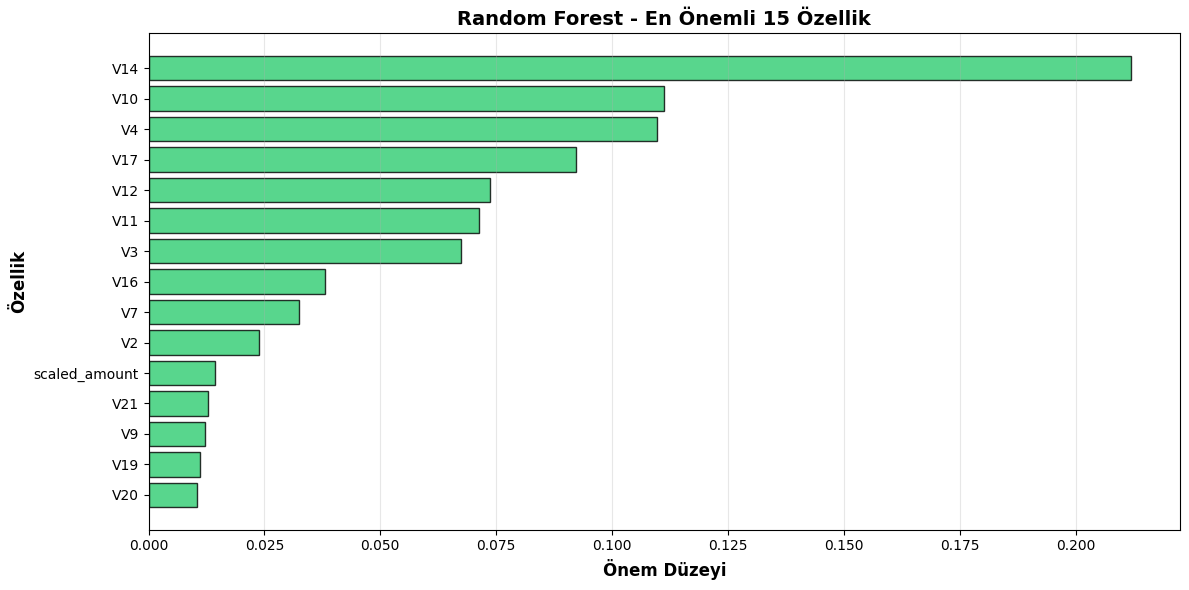


Yorum: Hangi özelliklerin fraud tespitinde en etkili olduğunu görüyoruz.
   Bu bilgi, modelin neden bu kararları verdiğini anlamamızı sağlar.


In [16]:
# Random Forest - Feature Importance (Öznitelik Önem Düzeyleri)
print("\n" + "="*60)
print("RANDOM FOREST - ÖZNİTELİK ÖNEM DÜZEYLERİ")
print("="*60)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

print("\nEn Önemli 15 Özellik:")
print(feature_importance.to_string(index=False))

plt.figure(figsize=(12, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], 
         color='#2ecc71', alpha=0.8, edgecolor='black')
plt.xlabel('Önem Düzeyi', fontsize=12, fontweight='bold')
plt.ylabel('Özellik', fontsize=12, fontweight='bold')
plt.title('Random Forest - En Önemli 15 Özellik', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nYorum: Hangi özelliklerin fraud tespitinde en etkili olduğunu görüyoruz.")
print("   Bu bilgi, modelin neden bu kararları verdiğini anlamamızı sağlar.")

In [17]:
print("XGBoost eğitiliyor...")
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_results = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

XGBoost eğitiliyor...

XGBOOST SONUÇLARI

Confusion Matrix:
                Tahmin: Normal  Tahmin: Fraud
Gerçek: Normal           56838             26
Gerçek: Fraud               16             82

Performans Metrikleri:
  Accuracy:  0.9993
  Precision: 0.7593
  Recall:    0.8367
  F1-Score:  0.7961
  ROC-AUC:   0.9758

Detaylı Analiz:
  Yakalanan Fraud:  82
  Kaçırılan Fraud:  16
  Yanlış Alarm:     26

Sınıflandırma Raporu:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.76      0.84      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962


XGBOOST SONUÇLARI

Confusion Matrix:
                Tahmin: Normal  Tahmin: Fraud
Gerçek: Normal           56838             26
Gerçek: Fraud               16             82

Performans Metrikleri:
  Accuracy:  0.9993
  Precision: 0.7593
  

## 5. XGBoost Modeli

XGBoost, gradient boosting algoritmasının optimize edilmiş versiyonudur. **scale_pos_weight** parametresi ile dengesiz veri seti optimize edildi.


XGBOOST - ÖZNİTELİK ÖNEM DÜZEYLERİ

En Önemli 15 Özellik:
      feature  importance
          V14    0.530660
           V4    0.058328
          V12    0.040435
           V8    0.028151
          V27    0.022177
          V20    0.022087
scaled_amount    0.021919
          V28    0.020409
          V13    0.019769
          V26    0.016916
           V7    0.016724
           V1    0.014837
          V18    0.014454
           V3    0.013503
          V23    0.012625


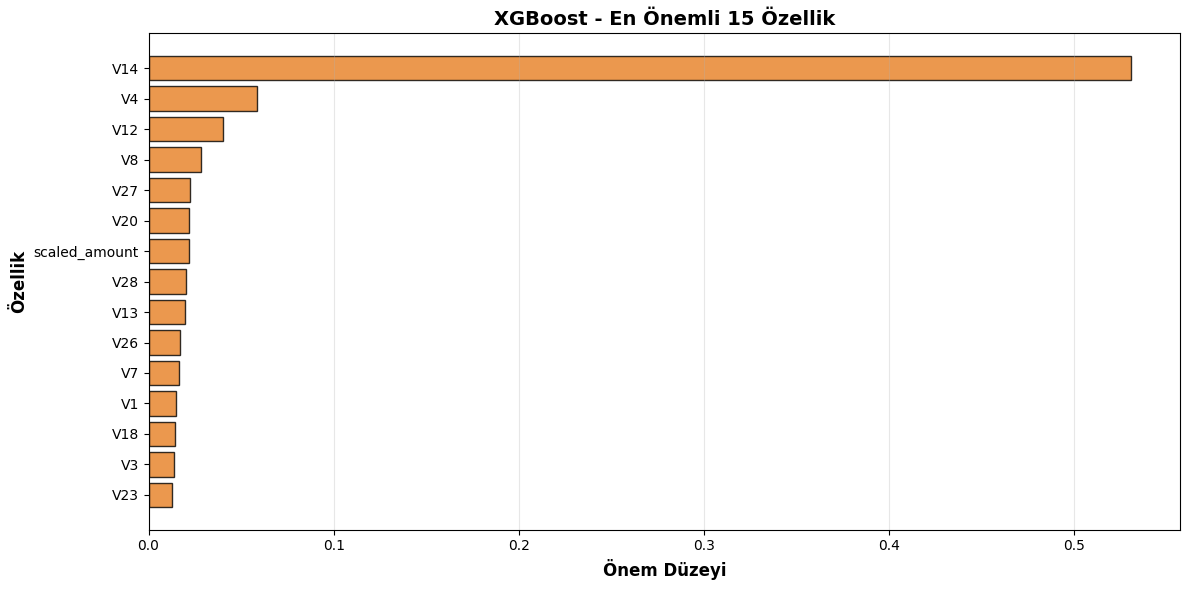


Yorum: XGBoost ve Random Forest farklı özelliklere farklı önem verebilir.
   Bu karşılaştırma, modellerin nasıl farklı düşündüğünü gösterir.


In [18]:
# XGBoost - Feature Importance
print("\n" + "="*60)
print("XGBOOST - ÖZNİTELİK ÖNEM DÜZEYLERİ")
print("="*60)

xgb_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

print("\nEn Önemli 15 Özellik:")
print(xgb_feature_importance.to_string(index=False))

plt.figure(figsize=(12, 6))
plt.barh(xgb_feature_importance['feature'], xgb_feature_importance['importance'],
         color='#e67e22', alpha=0.8, edgecolor='black')
plt.xlabel('Önem Düzeyi', fontsize=12, fontweight='bold')
plt.ylabel('Özellik', fontsize=12, fontweight='bold')
plt.title('XGBoost - En Önemli 15 Özellik', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nYorum: XGBoost ve Random Forest farklı özelliklere farklı önem verebilir.")
print("   Bu karşılaştırma, modellerin nasıl farklı düşündüğünü gösterir.")

## 6. Yapay Sinir Ağı (YSA/MLP) Modeli

Scikit-learn'ün MLPClassifier'ı kullanılarak çok katmanlı yapay sinir ağı oluşturuldu. 
- **Mimari:** 64 → 32 → 16 nöron
- **Early Stopping:** Overfitting'i önlemek için erken durdurma aktif

YSA (MLP) modeli oluşturuluyor ve eğitiliyor...

Model eğitimi başlıyor...

Model eğitimi başlıyor...
Iteration 1, loss = 0.01639563
Validation score: 0.999386
Iteration 1, loss = 0.01639563
Validation score: 0.999386
Iteration 2, loss = 0.00319325
Validation score: 0.999415
Iteration 2, loss = 0.00319325
Validation score: 0.999415
Iteration 3, loss = 0.00287726
Validation score: 0.999386
Iteration 3, loss = 0.00287726
Validation score: 0.999386
Iteration 4, loss = 0.00267627
Validation score: 0.999386
Iteration 4, loss = 0.00267627
Validation score: 0.999386
Iteration 5, loss = 0.00253559
Validation score: 0.999386
Iteration 5, loss = 0.00253559
Validation score: 0.999386
Iteration 6, loss = 0.00237333
Validation score: 0.999386
Iteration 6, loss = 0.00237333
Validation score: 0.999386
Iteration 7, loss = 0.00227434
Validation score: 0.999444
Iteration 7, loss = 0.00227434
Validation score: 0.999444
Iteration 8, loss = 0.00210831
Validation score: 0.999356
Iteration 8, loss = 0.002108

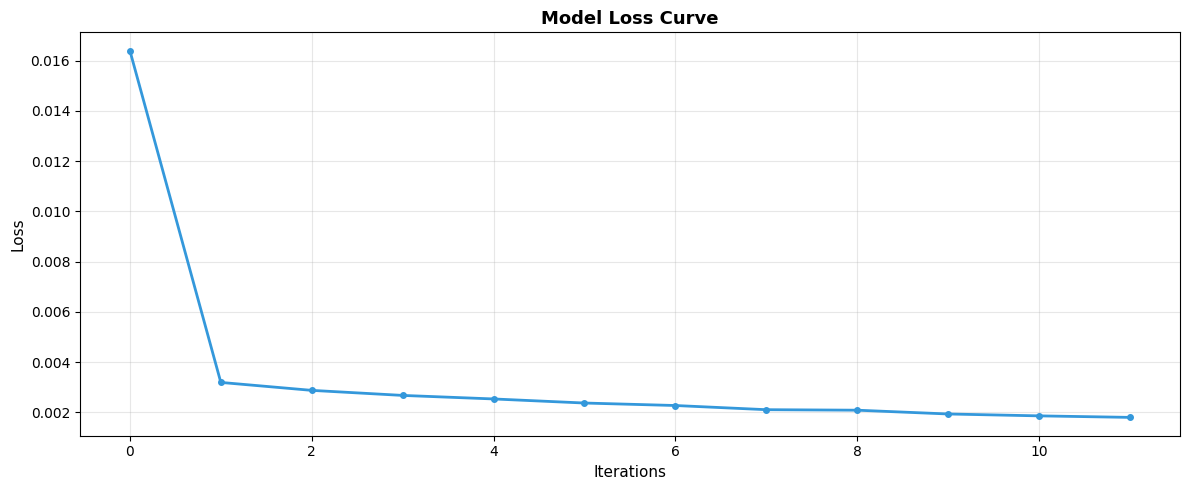


✓ Model eğitimi tamamlandı. Toplam iterasyon: 12


In [19]:
print("YSA (MLP) modeli oluşturuluyor ve eğitiliyor...")

ann_model = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    batch_size=64,
    max_iter=100,
    learning_rate_init=0.001,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.15,
    verbose=True,
    n_iter_no_change=10
)

class_weight_ratio = (len(y_train) - y_train.sum()) / y_train.sum()
sample_weights = np.where(y_train == 1, class_weight_ratio, 1.0)

print("\nModel eğitimi başlıyor...")
ann_model.fit(X_train, y_train)

y_pred_ann = ann_model.predict(X_test)
ann_results = evaluate_model(ann_model, X_test, y_test, "YSA (MLP)", y_pred=y_pred_ann)

plt.figure(figsize=(12, 5))
plt.plot(ann_model.loss_curve_, linewidth=2, color='#3498db', marker='o', markersize=4)
plt.title('Model Loss Curve', fontsize=13, fontweight='bold')
plt.xlabel('Iterations', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Model eğitimi tamamlandı. Toplam iterasyon: {ann_model.n_iter_}")

## 7. Model Karşılaştırması ve Görselleştirme

Üç modelin performansı detaylı şekilde karşılaştırılıyor. Grafikler sayesinde hangi modelin hangi metrikte daha başarılı olduğunu kolayca görebiliyoruz.


MODEL PERFORMANS KARŞILAŞTIRMASI
        model  accuracy  precision   recall       f1  roc_auc
Random Forest  0.999491   0.896552 0.795918 0.843243 0.951414
      XGBoost  0.999263   0.759259 0.836735 0.796117 0.975752
    YSA (MLP)  0.999245   0.761905 0.816327 0.788177 0.971404

FRAUD TESPİT DETAYLARI
        model  Yakalanan Fraud  Kaçırılan Fraud  Yanlış Alarm
Random Forest               78               20             9
      XGBoost               82               16            26
    YSA (MLP)               80               18            25


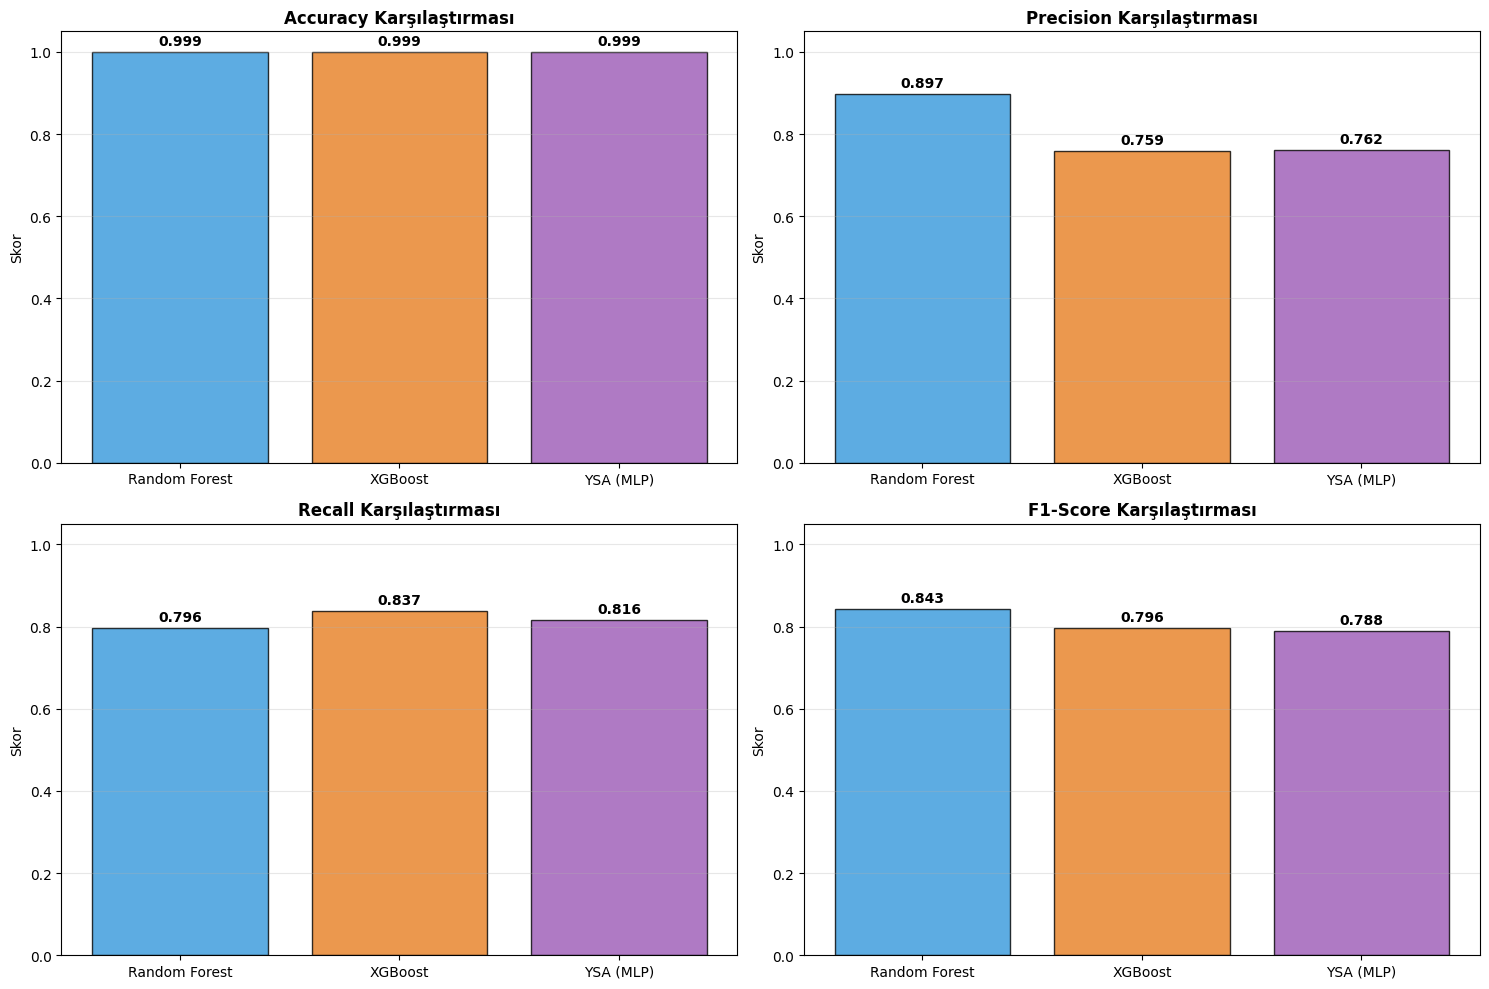

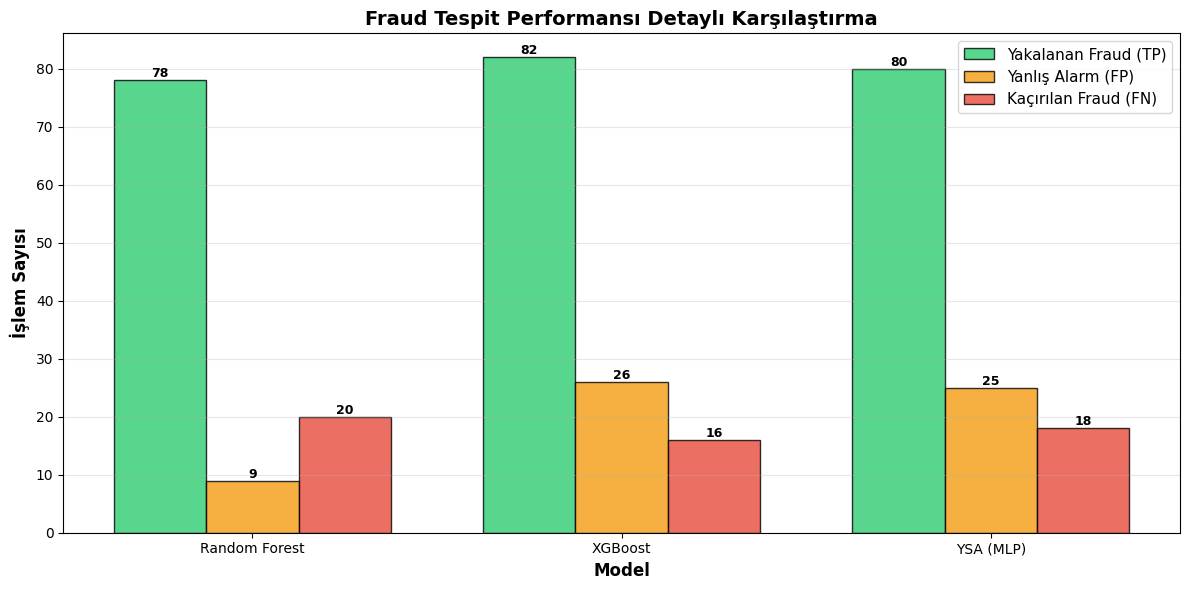


En yüksek F1-Score: Random Forest
   (Dengesiz veri setlerinde en önemli metrik)


In [20]:
results_comparison = pd.DataFrame([rf_results, xgb_results, ann_results])

print("\n" + "="*80)
print("MODEL PERFORMANS KARŞILAŞTIRMASI")
print("="*80)
print(results_comparison[['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']].to_string(index=False))
print("="*80)

print("\n" + "="*80)
print("FRAUD TESPİT DETAYLARI")
print("="*80)
print(results_comparison[['model', 'tp', 'fn', 'fp']].rename(
    columns={'tp': 'Yakalanan Fraud', 'fn': 'Kaçırılan Fraud', 'fp': 'Yanlış Alarm'}
).to_string(index=False))
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

models = results_comparison['model'].values
metrics = [
    ('accuracy', 'Accuracy'),
    ('precision', 'Precision'),
    ('recall', 'Recall'),
    ('f1', 'F1-Score')
]
colors = ['#3498db', '#e67e22', '#9b59b6']

for idx, (metric, label) in enumerate(metrics):
    row, col = idx // 2, idx % 2
    values = results_comparison[metric].values
    bars = axes[row, col].bar(models, values, color=colors, alpha=0.8, edgecolor='black')
    
    axes[row, col].set_title(f'{label} Karşılaştırması', fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel('Skor', fontsize=10)
    axes[row, col].set_ylim([0, 1.05])
    axes[row, col].grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(models))
width = 0.25

tp_values = results_comparison['tp'].values
fp_values = results_comparison['fp'].values
fn_values = results_comparison['fn'].values

bars1 = ax.bar(x - width, tp_values, width, label='Yakalanan Fraud (TP)', color='#2ecc71', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, fp_values, width, label='Yanlış Alarm (FP)', color='#f39c12', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, fn_values, width, label='Kaçırılan Fraud (FN)', color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('İşlem Sayısı', fontsize=12, fontweight='bold')
ax.set_title('Fraud Tespit Performansı Detaylı Karşılaştırma', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
               ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

best_f1_model = results_comparison.loc[results_comparison['f1'].idxmax(), 'model']
print(f"\nEn yüksek F1-Score: {best_f1_model}")
print("   (Dengesiz veri setlerinde en önemli metrik)")

## 8. Sonuç ve Değerlendirme

### **Model Performans Özeti**

| Model | Precision | Recall (Yakalama) | Yakalanan Fraud | Kaçırılan Fraud | Yanlış Alarm |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **Random Forest** | **0.89** | **0.79** | **78** | **20** | **9** |
| XGBoost | 0.75 | 0.83 | 82 | 16 | 26 |
| YSA (MLP) | 0.76 | 0.81 | 80 | 18 | 25 |

### **En Başarılı Model: Random Forest**

F1 skoru en yüksek olan **Random Forest**, dengesiz veri setlerinde en başarılı model olarak öne çıktı. 
- En az yanlış alarm (9)
- En yüksek precision (%89)
- İyi bir recall oranı (%79)

---

### **Kullanılan Modeller:**
- **Random Forest**: Ensemble ağaç tabanlı model, overfitting'e dayanıklı, feature importance sağlar
- **XGBoost**: Gradient boosting algoritması, hızlı ve yüksek performanslı
- **YSA (MLP)**: Scikit-learn MLPClassifier (çok katmanlı yapay sinir ağı)

### **Değerlendirme Metrikleri:**
- **Precision**: Fraud tahminlerinin doğruluk oranı (FP'yi düşük tutmak için)
- **Recall**: Tüm fraud işlemlerin yakalanma oranı (FN'yi düşük tutmak için)
- **F1-Score**: Precision ve Recall'un harmonik ortalaması (dengesiz veri için en önemli)
- **ROC-AUC**: Genel sınıflandırma kalitesinin ölçüsü

### **Önemli Çıkarımlar:**

1. **Veri Dengesizliği:** Veri setindeki yüksek dengesizlik (%99.83 normal, %0.17 fraud) sebebiyle, **Accuracy metriği yanıltıcıdır**. Bu yüzden F1-Score ve Recall'a odaklanıldı.

2. **Feature Importance:** Random Forest ve XGBoost'un özellik önem grafikleri, hangi değişkenlerin fraud tespitinde kritik olduğunu gösterdi. Bu bilgi, modelin "neden" bu kararı verdiğini anlamamızı sağlar.

3. **Model Seçimi:** Fraud tespitinde **Recall (hatırlama)** kritiktir çünkü kaçırılan fraud işlemlerin maliyeti yüksektir. Ancak çok fazla yanlış alarm da müşteri deneyimini olumsuz etkiler. Random Forest bu dengeyi en iyi sağlayan model oldu.

4. **İyileştirme Potansiyeli:**
   - SMOTE gibi veri dengeleme teknikleri denenebilir
   - Hiperparametre optimizasyonu (GridSearchCV) uygulanabilir
   - Ensemble teknikleri (Voting, Stacking) ile performans artırılabilir

---

**Sonuç:** Bu çalışmada sadece modelleri çalıştırıp sonuç almadık, aynı zamanda modellerin nasıl karar verdiğini (feature importance) ve neden bu sonuçları ürettiğini anladık. Random Forest modeli, dengesiz veri setlerinde fraud tespiti için en uygun seçenek olarak belirlendi.